In [1]:
import os
import pandas as pd
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict


datapath = Path('/home/jseia/Desktop/thesis/data/')
csv_path = Path('/home/jseia/Desktop/thesis/code/stroke-seg/data/dataset.csv')
base_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/nnunetv2')
os.environ['nnUNet_raw'] = str(base_path/'nnUNet_raw')
os.environ['nnUNet_preprocessed'] = str(base_path/'preprocessed')
os.environ['nnUNet_results'] = str(base_path/'nnUNet_trained_models')

from DeSD.model_interpreter import EmpeddingProjector, NetProjector, CAMProjector, DimReductor, SaliencyGenerator

import sys ; sys.path.insert(0, '/home/jseia/Desktop/thesis/code/stroke-seg')
from dataset.dataset import StrokeDataset
import sys ; sys.path.remove('/home/jseia/Desktop/thesis/code/stroke-seg')

dataset = StrokeDataset(
    datapath=datapath,
    datasets=['apis', 'aisd', 'tum', 'tbi'], 
    data_csv_path=csv_path,
    cases_to_exclude=[],
    pathology=['ais', 'normal'],
    modalities=['ncct', 'ncct-tilt'],
    partitions=['validation'],
    standard=['gold', 'silver', '-'],
    filter_discard=True
)

base_cfg_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/ssl_pretrain/')
base_experiments_path = Path('/home/jseia/Desktop/thesis/experiments/')

In [2]:
# import torch
# from collections import OrderedDict
# from pathlib import Path

# base_path = Path('/home/jseia/Desktop/thesis/experiments/nnunet_encoder/non_tbi/')
# src_path = base_path / 'checkpoint_best_Dataset043_AIS_FS_r0.pth'
# # base_path = Path('/home/jseia/Desktop/thesis/experiments/nnunet_encoder/tum/')
# # src_path = base_path / 'checkpoint_best_Dataset046_AIS_FS_r0.pth'

# ref_path = Path('/home/jseia/Desktop/thesis/experiments/all_ncct/000/checkpoint.pth')
# src = torch.load(src_path)
# ssl_checkpoint = torch.load(ref_path)
# ssl_encoder = {'network_weights': {}}

# for k, v in src['network_weights'].items():
#     if ("encoder" in k) and ("decoder" not in k):
#         k = str(k).replace('encoder', 'backbone.net')
#         ssl_checkpoint['teacher'][k] = v

# for k, v in src['network_weights'].items():
#     if 'encoder' in k:
#         ssl_encoder['network_weights'][k] = v

# ssl_checkpoint['teacher'] = OrderedDict(ssl_checkpoint['teacher'])
# ssl_encoder['network_weights'] = OrderedDict(ssl_encoder['network_weights'])
# torch.save(ssl_checkpoint, base_path/'checkpoint.pth')
# torch.save(ssl_encoder, base_path/'ssl_checkpoint.pth')

In [3]:
import captum.attr as attr

base_cfg_path = Path('/home/jseia/Desktop/thesis/code/nnUNet_ais/DeSD/cfg_files/ssl_pretrain/')
base_experiments_path = Path('/home/jseia/Desktop/thesis/experiments/')

def get_saliency_maps(exps_cfgs: List[Dict], dataset, force: bool = True):
    for exp_cfg in exps_cfgs:
        cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        out_path = exp_path / 'attribution'
        if not out_path.exists() or force:
            saliency_gen = SaliencyGenerator(
                cfg_file_path=base_cfg_path/exp_cfg['data']/cfg_filename,
                chckpt_file_path=exp_path/'checkpoint.pth',
                device='cuda', dataset=dataset,
                method=attr.IntegratedGradients,
                layer=False, suffix='ig')
            subjects = dataset.df.loc[dataset.df.dataset_name == 'tum', 'subject'].unique().tolist()
            print(subjects)
            saliency_gen(subjects, save_saliency=True, out_path=out_path)
exps_cfgs = [
    {'data': 'nnunet_encoder', 'exp': 'tum', 'context': '-'}, # FS TUM (Dataset046_AIS_FS_r0)
    {'data': 'nnunet_encoder', 'exp': 'non_tbi', 'context': '-'}, # FS NON-TBI (Dataset043_AIS_FS_r0)
]
# get_saliency_maps(exps_cfgs, dataset)

In [4]:
# def get_projections(exps_cfgs: List[Dict], dataset, force: bool = True):
#     for exp_cfg in tqdm(exps_cfgs):
#         cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
#         exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
#         csv_path = exp_path/'complete_vol_embeddings.csv'
#         if not csv_path.exists() or force:
#             embedding_projector = EmpeddingProjector(
#                 cfg_file_path=base_cfg_path/exp_cfg['data']/cfg_filename,
#                 chckpt_file_path=exp_path/'checkpoint.pth',
#                 device='cuda', batch_size=1
#             )
#             embeddings = embedding_projector(dataset=dataset)
#             embeddings['dataset'] = exp_cfg["data"]
#             embeddings['context'] = exp_cfg["context"]
#             embeddings.to_csv(csv_path)
#         else:
#             embeddings = pd.read_csv(csv_path, index_col=0)

#         projections_csv_path = exp_path/'complete_vol_reductions.csv'
#         if not projections_csv_path.exists() or force:
#             projections = pd.DataFrame()
#             for method in ['pca', 'tsne', 'umap']:
#                 method_kwargs = {'n_components': 2, 'random_state': 0}
#                 if method == 'tsne':
#                     method_kwargs.update({'learning_rate': 'auto', 'init': 'pca'})
#                 reductor = DimReductor(method=method, method_kwargs=method_kwargs)
#                 method_projections = reductor(embeddings)
#                 meta_cols = [col for col in method_projections.columns if 'feat' not in col]
#                 projections[meta_cols] = method_projections[meta_cols].values
#                 projections[[f'{method}0', f'{method}1']] = method_projections[['feat0', 'feat1']].values
#             projections['dataset'] = exp_cfg["data"]
#             projections['context'] = exp_cfg["context"]
#             projections.to_csv(projections_csv_path)
#         else:
#             projections = pd.read_csv(projections_csv_path, index_col=0)

# exps_cfgs = [
#     # {'data': 'nnunet_encoder', 'exp': 'tum', 'context': '-'}, # FS TUM (Dataset046_AIS_FS_r0)
#     {'data': 'nnunet_encoder', 'exp': 'non_tbi', 'context': '-'}, # FS NON-TBI (Dataset043_AIS_FS_r0)
# ]

# get_projections(exps_cfgs, dataset)

In [5]:
import numpy as np
from scipy.spatial import KDTree
from nnunetv2.paths import nnUNet_preprocessed, nnUNet_raw
from typing import List, Dict
import yaml
import SimpleITK as sitk
import json
from typing import Dict

def adapt_size(img, destiny_shape):
    if img.shape == destiny_shape:
        return img
    for i in range(len(img.shape)):
        diff = img.shape[i] - destiny_shape[i]
        half = diff // 2
        other_half = diff - half
        if diff > 0:
            if i == 0:
                img = img[half:img.shape[0]-other_half, :]
            else:
                img = img[:, half:img.shape[1]-other_half]
        elif diff < 0:
            half, other_half = np.abs(half), np.abs(other_half)
            padd = ((half, other_half), (0, 0))
            padd = padd if (i == 0) else (padd[1], padd[0])
            img = np.pad(img, padd, 'minimum')
    return img

def visualize_neighbours(
    exp_cfg: Dict, projections: pd.DataFrame, feat_prefix: str,
    k: int = 3, preproc: bool = False) -> np.ndarray:
    
    centers = exp_cfg['centers'][feat_prefix]
    
    exp_path = base_cfg_path / exp_cfg['data']
    cfg_filename = f'config_{exp_cfg["data"]}_{exp_cfg["exp"]}.yml'
    with open(exp_path/cfg_filename, 'r') as yfile:
        cfg = yaml.safe_load(yfile)['training']
    
    pp_path = Path(nnUNet_preprocessed) / cfg['dataset']
    dataset_fgpt = pp_path / 'nnUNetPlansSSL.json'
    with open(dataset_fgpt, 'r') as jfile:
        dataset_fgpt = json.load(jfile)
    destiny_shape = dataset_fgpt['original_median_shape_after_transp']

    pp_path = pp_path / f'{cfg["exp_planner"]}_{cfg["configuration"]}'
    raw_path = Path(nnUNet_raw) / cfg['dataset'] / f'imagesTr'
    
    projections.reset_index(drop=True, inplace=True)
    tree = KDTree(projections[[f'{feat_prefix}0', f'{feat_prefix}1']].values)
    _, indexes = tree.query(np.asarray(centers),  k=k)
    rows = []
    for pts_idxs in indexes:
        imgs = []
        for pt_idx in pts_idxs:
            subject = projections.iloc[pt_idx].subject
            if preproc:
                filename = pp_path / f'{subject}.npy'
                img = np.load(filename)[0, ...]
                # print(img.shape)
            else:
                filename = raw_path / f'{subject}_0000.nii.gz'
                img = sitk.GetArrayFromImage(sitk.ReadImage(str(filename)))
                # print(img.shape)
            middle_slice = img.shape[0]//2
            # print(destiny_shape[1:])
            g = adapt_size(img[middle_slice, :, :], destiny_shape[1:])
            # print(g.shape)
            imgs.append(g)
        rows.append(np.concatenate(imgs, axis=1))
    img = np.concatenate(rows, axis=0)
    return img

def scatter_examples_full(exps_cfgs, preproc, lims):
    palette_ds = {"tum": "C0", "apis": "C1", "aisd": "C2", "tbi": "C3"}
    # palette_ais ={True: "C0", False: "C1"}
    for exp_cfg in exps_cfgs:
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        embedding = pd.read_csv(exp_path/"complete_vol_reductions.csv", index_col=0)
        plot_images = ('centers' in exp_cfg.keys()) and (exp_cfg['centers'] is not None)
        if plot_images:
            figsize = (10, 6)
            fg, ax = plt.subplots(2, 3, figsize=figsize, constrained_layout=True)
        else:
            figsize = (10, 3)
            fg, ax = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)
        for k, method in enumerate(['pca', 'tsne', 'umap']):
            # PLOT SCATTERPLOT
            axk = ax[0, k] if plot_images else ax[k]
            legend = 'auto' if k == 2 else False
            sns.scatterplot(embedding, x=f'{method}0', y=f'{method}1',
                            hue='dataset_name', ax=axk, palette=palette_ds,
                            legend=legend, s=20, style="dataset_name")
            axk.set_title(f'{method.upper()}')
            
            if plot_images:
                centers = np.asarray(exp_cfg['centers'][method])
                sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=23, ax=axk,
                                style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
            if legend == 'auto':
                handles, labels = axk.get_legend_handles_labels()
                axk.legend(handles[:4], labels[:4], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Dataset')
            sns.despine()
            
            if plot_images:
                # PLOT EXAMPLES
                img = visualize_neighbours(exp_cfg, embedding, feat_prefix=method, k=6, preproc=preproc)
                sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=23, ax=ax[1, k],
                                style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
                ax[1, k].imshow(img, cmap='gray') #, vmin=lims[0], vmax=lims[1])
                if k == 2:
                    ax[1, k].legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
                ax[1, k].axis('off')

        # plt.tight_layout()
        fg.suptitle(f'Dimensionality reductions for experiment: ' \
                    f'{exp_cfg["data"]} - {exp_cfg["context"]}', fontsize=12)
        plt.tight_layout()
        plt.show()

def scatter_examples_method(exps_cfgs, preproc, lims, method):
    palette_ds = {"tum": "C0", "apis": "C1", "aisd": "C2", "tbi": "C3"}
    # palette_ais ={True: "C0", False: "C1"}
    for exp_cfg in exps_cfgs:
        exp_path = base_experiments_path / exp_cfg['data'] / exp_cfg["exp"]
        embedding = pd.read_csv(exp_path/"complete_vol_reductions.csv", index_col=0)
        plot_images = ('centers' in exp_cfg.keys()) and (exp_cfg['centers'] is not None)
        if plot_images:
            figsize = (9, 4)
            fg, ax = plt.subplots(1, 2, figsize=figsize, constrained_layout=True)
        else:
            figsize = (5, 4)
            fg, ax = plt.subplots(1, 1, figsize=figsize, constrained_layout=True)
        
        # PLOT SCATTERPLOT
        axk = ax[0] if plot_images else ax
        legend = 'auto'
        sns.scatterplot(embedding, x=f'{method}0', y=f'{method}1',
                        hue='dataset_name', ax=axk, palette=palette_ds,
                        legend=legend, s=20, style="dataset_name")
        axk.set_title(f'{method.upper()}')
        
        if plot_images:
            centers = np.asarray(exp_cfg['centers'][method])
            sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=40, ax=axk,
                            style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
        if legend == 'auto':
            handles, labels = axk.get_legend_handles_labels()
            h, l = handles[4:], labels[4:]
            axk.legend(handles[:4], labels[:4], loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='Dataset')
        sns.despine()
        
        if plot_images:
            # PLOT EXAMPLES
            img = visualize_neighbours(exp_cfg, embedding, feat_prefix=method, k=6, preproc=preproc)
            # sns.scatterplot(x=centers[:, 0], y=centers[:, 1], color='k', s=23, ax=ax[1],
            #                 style=np.arange(4), markers=['o', 'v', 's', 'P'], legend=legend)
            ax[1].imshow(img, cmap='gray', vmin=lims[0], vmax=lims[1])
            ax[1].legend(h, l, loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, title='rows')
            ax[1].axis('off')

        # plt.tight_layout()
        fg.suptitle(f'Dimensionality reductions for experiment: ' \
                    f'{exp_cfg["data"]} - {exp_cfg["context"]}', fontsize=12)
        plt.tight_layout()
        plt.show()

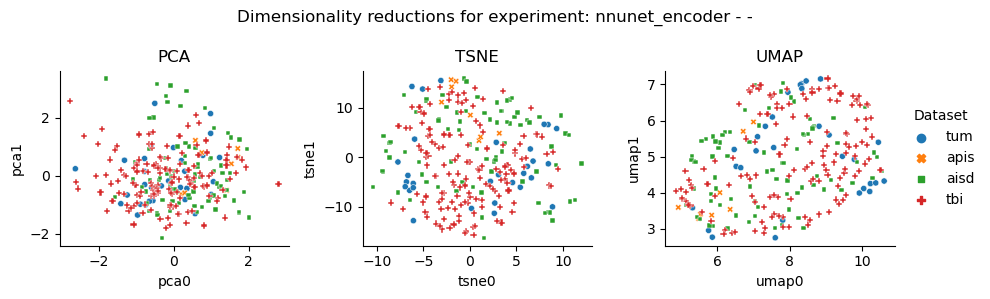

In [6]:
%matplotlib inline
exps_cfgs = [
    {'data': 'nnunet_encoder', 'exp': 'tum', 'context': '-'},
]

preproc = False
lims = [-5, 4] if preproc else [0, 80]
scatter_examples_full(exps_cfgs, preproc, lims)